In [0]:
!pip install tensorflow==1.13.1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls "/content/drive/My Drive/MURA-v1.1"

In [0]:
from keras.applications import densenet, mobilenet, vgg16, inception_v3
from keras.models import Model
from keras.layers import Dense, Activation, concatenate
from keras import optimizers,losses
from keras.utils import np_utils
from sklearn.utils import shuffle
import numpy as np
from PIL import Image ,ImageOps
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **Load Data**

In [0]:
def get_study_level_data(study_type):
    """
    Returns a dict, with keys 'train' and 'valid' and respective values as study level dataframes, 
    these dataframes contain three columns 'Path', 'Count', 'Label'
    Args:
        study_type (string): one of the seven study type folder names in 'train/valid/test' dataset 
    """
    data_cat = ['train', 'valid']
    study_data = {}
    study_label = {'positive': 1, 'negative': 0}
    for phase in data_cat:
        BASE_DIR = '/content/drive/My Drive/MURA-v1.1/%s/%s/' % (phase , study_type)
        patients = list(os.walk(BASE_DIR))[0][1] # list of patient folder names
        study_data[phase] = pd.DataFrame(columns=['Path', 'Count', 'Label'])
        i = 0
        for patient in tqdm(patients): # for each patient folder
            for study in os.listdir(BASE_DIR + patient): # for each study in that patient folder
                label = study_label[study.split('_')[1]] # get label 0 or 1
                path = BASE_DIR + patient + '/' + study + '/' # path to this study
                study_data[phase].loc[i] = [path, len(os.listdir(path)), label] # add new row
                i+=1
    return study_data

In [0]:
def load_training_data(size_x,size_y):
  images_train=[]
  labels_train=[]
  for idx in tqdm(range(study_data['train'].shape[0])):
    study_path = study_data['train'].iloc[idx, 0]
    count = study_data['train'].iloc[idx, 1]
    for i in range(count):
        img=Image.open(study_path + 'image%s.png' % (i+1))
        re_img=img.resize((size_x,size_y))
        re_img=np.array(re_img)
#         re_img =preprocess_input(re_img)
        if len(re_img.shape)< 3:
          re_img=cv.cvtColor(re_img,cv.COLOR_GRAY2RGB)
        images_train.append( re_img)
        labelimg=study_data['train'].iloc[idx, 2]    
        labelimg=np.array(labelimg)
        labels_train.append(labelimg)
  images_train=np.array(images_train)
  labels_train=np.array(labels_train)
  return images_train,labels_train

In [0]:
def load_test_data(size_x,size_y):
  images_test=[]
  labels_test=[]
  for idx in tqdm(range(study_data['valid'].shape[0])):
    study_path = study_data['valid'].iloc[idx, 0]
    count = study_data['valid'].iloc[idx, 1]
    for i in range(count):
        img=Image.open(study_path + 'image%s.png' % (i+1))
        re_img=img.resize((size_x,size_y))
        re_img=np.array(re_img)
#         re_img = preprocess_input(re_img)
        if len(re_img.shape)< 3:
          re_img=cv.cvtColor(re_img,cv.COLOR_GRAY2RGB)
        images_test.append(re_img)
        labelimg=study_data['valid'].iloc[idx, 2]
        labelimg=np.array(labelimg)
        labels_test.append(labelimg)
  images_test=np.array(images_test)
  labels_test=np.array(labels_test) 
  return images_test,labels_test

In [0]:
study_data=get_study_level_data('XR_HUMERUS')

In [0]:
study_data

In [0]:
images_train,labels_train=load_training_data(224,224)

100%|██████████| 592/592 [00:09<00:00, 64.48it/s]


In [0]:
images_test,labels_test =load_test_data(224,224)

100%|██████████| 135/135 [00:01<00:00, 72.59it/s]


In [0]:
images_train,labels_train=shuffle(images_train,labels_train,random_state=4)

In [0]:
labels_train_cat = np_utils.to_categorical(labels_train, 2)
labels_test_cat = np_utils.to_categorical(labels_test, 2)

# **Data Augmentation**

In [0]:
train_datagen=ImageDataGenerator( featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
                                    horizontal_flip=True,validation_split=0.2)

In [0]:
def fit_Augmentaion(model):
  model.fit_generator(train_datagen.flow(x=images_train,y=labels_train_cat,batch_size=32),epochs=5,steps_per_epoch=(images_train.shape[0] // 32))

# **Functions preparations**

In [0]:
def compile(model):
  model.compile(optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
def fit(model):
  model.fit(x=images_train,y=labels_train_cat,batch_size=32,epochs=5,validation_split=0.2)

In [0]:
def evaluate(model):
  test_eval = model.evaluate(x=images_test, y=labels_test_cat, verbose=0)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])

In [0]:
def predict(model):
  predictions=model.predict(images_test,verbose=1)
  return predictions

In [0]:
def plot_confusion_matrix(prediction):
  print("classification_report :  \n ", classification_report(np.argmax(labels_test_cat,axis=1),np.argmax(prediction,axis=1)))
  accuracy = accuracy_score(np.argmax(labels_test_cat,axis=1), np.argmax(prediction,axis=1))
  print(f'accuracy: {accuracy}')
  cm = pd.DataFrame(confusion_matrix(np.argmax(labels_test_cat,axis=1), np.argmax(prediction,axis=1)))
  sb.heatmap(cm,annot=True)
  plt.show()

# **DenseNet**

In [0]:
def DenseNetModel():
  dense = densenet.DenseNet169()
  dense.summary()
  x = dense.layers[-2].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=dense.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

Model

In [0]:
dense_model=DenseNetModel()

In [0]:
!pip install tensorflow-gpu==1.13.1

Train

In [0]:
fit(dense_model)

In [0]:
fit_Augmentaion(dense_model)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


39/39 [==============================] - 18s 473ms/step - loss: 0.4100 - acc: 0.8432
Epoch 2/5
39/39 [==============================] - 17s 445ms/step - loss: 0.3706 - acc: 0.8453
Epoch 3/5
39/39 [==============================] - 17s 435ms/step - loss: 0.2466 - acc: 0.9116
Epoch 4/5
39/39 [==============================] - 17s 441ms/step - loss: 0.2041 - acc: 0.9241
Epoch 5/5
39/39 [==============================] - 17s 436ms/step - loss: 0.1395 - acc: 0.9455


Test

In [0]:
evaluate(dense_model)

Test loss: 0.5081416407807006
Test accuracy: 0.8645833333333334


Predict

In [0]:
dense_predictions=predict(dense_model)
print(dense_predictions[250])
print(labels_test_cat[250])

288/288 [==============================] - 4s 14ms/step
[0.9260908  0.07390928]
[1. 0.]


Confusion Matrix

In [0]:
dense_model.save("drive/My Drive/model/denseModel.h5")

classification_report :  
                precision    recall  f1-score   support

           0       0.90      0.82      0.86       148
           1       0.83      0.91      0.87       140

    accuracy                           0.86       288
   macro avg       0.87      0.87      0.86       288
weighted avg       0.87      0.86      0.86       288

accuracy: 0.8645833333333334


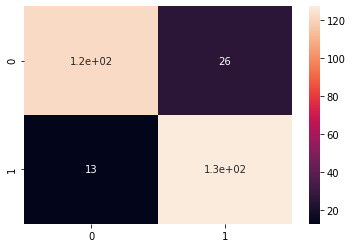

In [0]:
plot_confusion_matrix(dense_predictions)

# **VGG**

Model

In [0]:
def VGG():
  vgg =vgg16.VGG16()
  vgg.summary()
  x = vgg.layers[-4].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=vgg.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

In [0]:
vgg_model=VGG()

Train

In [0]:
fit(vgg_model)

Train on 1017 samples, validate on 255 samples
Epoch 1/5
1017/1017 [==============================] - 18s 18ms/step - loss: 0.9211 - acc: 0.5870 - val_loss: 0.6910 - val_acc: 0.6314
Epoch 2/5
1017/1017 [==============================] - 8s 8ms/step - loss: 0.6281 - acc: 0.6578 - val_loss: 0.6173 - val_acc: 0.6549
Epoch 3/5
1017/1017 [==============================] - 8s 8ms/step - loss: 0.5496 - acc: 0.7316 - val_loss: 0.6286 - val_acc: 0.6667
Epoch 4/5
1017/1017 [==============================] - 8s 8ms/step - loss: 0.5178 - acc: 0.7404 - val_loss: 0.6004 - val_acc: 0.7098
Epoch 5/5
1017/1017 [==============================] - 8s 8ms/step - loss: 0.4323 - acc: 0.8073 - val_loss: 0.5744 - val_acc: 0.7176


In [0]:
fit_Augmentaion(vgg_model)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


39/39 [==============================] - 16s 411ms/step - loss: 0.6673 - acc: 0.6536
Epoch 2/5
39/39 [==============================] - 15s 390ms/step - loss: 0.6251 - acc: 0.6627
Epoch 3/5
39/39 [==============================] - 15s 389ms/step - loss: 0.5375 - acc: 0.7399
Epoch 4/5
39/39 [==============================] - 15s 388ms/step - loss: 0.5097 - acc: 0.7623
Epoch 5/5
39/39 [==============================] - 15s 388ms/step - loss: 0.5344 - acc: 0.7332


Test

In [0]:
evaluate(vgg_model)

Test loss: 0.47113390929169124
Test accuracy: 0.7777777777777778


Predict

In [0]:
vgg_predictions=predict(vgg_model)
print(vgg_predictions[250])
print(labels_test_cat[250])

288/288 [==============================] - 3s 11ms/step
[0.34157193 0.6584281 ]
[1. 0.]


Confusion Matrix

In [0]:
vgg_model.save('drive/My Drive/model/vggModel.h5')

classification_report :  
                precision    recall  f1-score   support

           0       0.88      0.66      0.75       148
           1       0.72      0.90      0.80       140

    accuracy                           0.78       288
   macro avg       0.80      0.78      0.78       288
weighted avg       0.80      0.78      0.78       288

accuracy: 0.7777777777777778


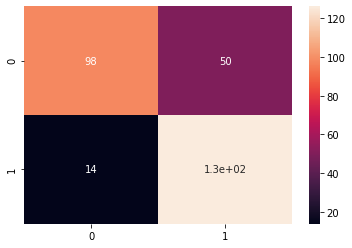

In [0]:
plot_confusion_matrix(vgg_predictions)

# **Inception**

Model

In [0]:
def Inception():
  inception = inception_v3.InceptionV3()
  inception.summary()
  x = inception.layers[-2].output
  predictions = Dense(2,activation = 'softmax')(x)
  model = Model(inputs=inception.input, outputs=predictions)
  model.summary()
  compile(model)
  return model

In [0]:
inception_model=Inception()

Train

In [0]:
fit(inception_model)

Train on 1017 samples, validate on 255 samples
Epoch 1/5
1017/1017 [==============================] - 36s 35ms/step - loss: 0.5297 - acc: 0.7335 - val_loss: 0.5437 - val_acc: 0.7529
Epoch 2/5
1017/1017 [==============================] - 10s 10ms/step - loss: 0.1767 - acc: 0.9371 - val_loss: 0.4961 - val_acc: 0.8078
Epoch 3/5
1017/1017 [==============================] - 11s 10ms/step - loss: 0.0427 - acc: 0.9921 - val_loss: 0.6591 - val_acc: 0.7882
Epoch 4/5
1017/1017 [==============================] - 11s 10ms/step - loss: 0.0186 - acc: 0.9980 - val_loss: 0.7758 - val_acc: 0.7961
Epoch 5/5
1017/1017 [==============================] - 11s 10ms/step - loss: 0.0222 - acc: 0.9961 - val_loss: 0.6606 - val_acc: 0.8314


In [0]:
fit_Augmentaion(inception_model)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


39/39 [==============================] - 29s 748ms/step - loss: 0.4236 - acc: 0.8432
Epoch 2/5
39/39 [==============================] - 26s 667ms/step - loss: 0.3537 - acc: 0.8547
Epoch 3/5
39/39 [==============================] - 26s 661ms/step - loss: 0.2419 - acc: 0.9028
Epoch 4/5
39/39 [==============================] - 26s 662ms/step - loss: 0.2184 - acc: 0.9087
Epoch 5/5
39/39 [==============================] - 25s 651ms/step - loss: 0.1866 - acc: 0.9319


Test

In [0]:
evaluate(inception_model)

Test loss: 0.6949283629655838
Test accuracy: 0.7951388888888888


Predict

In [0]:
inception_predictions=predict(inception_model)
print(inception_predictions[250])
print(labels_test_cat[250])

288/288 [==============================] - 7s 25ms/step
[0.96623313 0.03376681]
[1. 0.]


Confusion Matrix

In [0]:
inception_model.save('drive/My Drive/model/inceptionModel.h5')

classification_report :  
                precision    recall  f1-score   support

           0       0.75      0.90      0.82       148
           1       0.86      0.69      0.76       140

    accuracy                           0.80       288
   macro avg       0.81      0.79      0.79       288
weighted avg       0.81      0.80      0.79       288

accuracy: 0.7951388888888888


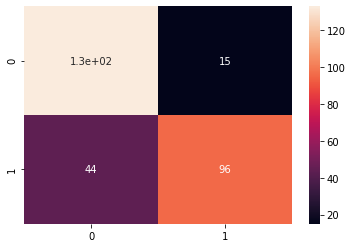

In [0]:
plot_confusion_matrix(inception_predictions)

# **Show the grad-CAM images for vgg16**

In [0]:
import keras
from keras.applications.vgg16 import (preprocess_input, decode_predictions)
from keras.preprocessing import image
from tensorflow.python.framework import ops
from keras.models import load_model
import keras.backend as K
import tensorflow as tf
import numpy as np
import cv2
import os

def grad_cam(model, x, category_index, layer_name):
    """
    Args:
       model: model
       x: image input
       category_index: category index
       layer_name: last convolution layer name
    """
    # get category loss
    class_output = model.output[:, category_index]

    # layer output
    convolution_output = model.get_layer(layer_name).output
    # get gradients
    grads = K.gradients(class_output, convolution_output)[0]
    # get convolution output and gradients for input
    gradient_function = K.function([model.input], [convolution_output, grads])

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # avg
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # create heat map
    cam = cv2.resize(cam, (x.shape[1], x.shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = x[0, :]
    image_rgb -= np.min(image_rgb)
    image_rgb = np.minimum(image_rgb, 255)

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image_rgb)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


model_vgg = load_model('drive/My Drive/model/vggModel.h5')
model_vgg.summary()

img = load_image('drive/My Drive/ELBOWdata/test/images/XR_ELBOW77.png')
predictions = model_vgg.predict(img)
predicted_class = np.argmax(predictions)
cam_image, heat_map = grad_cam(model_vgg, img, predicted_class, "block5_pool")



In [0]:
!pip install GPY
!pip install GPyOpt

In [0]:
import GPyOpt
from keras.preprocessing.image import array_to_img
def make_IOU(x, box):
    IOU_1, IOU_2 = 0, 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] == 1 or box[i, j] == 1:
                if x[i, j] == 1 and box[i, j] == 1:
                    IOU_1 += 1
                IOU_2 += 1
    IOU = IOU_1 / IOU_2
    return IOU
def make_box(x):
    def f(xx):
        x_begin, x_end, y_begin, y_end = xx[:,0], xx[:,1], xx[:,2], xx[:,3]

        # IOUの計算
        box = np.zeros(x.shape)
        box[int(y_begin):int(y_end),int(x_begin):int(x_end)] = 1
        IOU = make_IOU(x,box)
        #print("IOU", IOU)

    return -IOU
    bounds = [{'name': 'x_begin', 'type': 'continuous', 'domain': (0,x.shape[1]*0.75)},
              {'name': 'x_end', 'type': 'continuous', 'domain': (x.shape[1]*0.25, x.shape[1]-1)},
              {'name': 'y_begin', 'type': 'continuous', 'domain': (0,x.shape[0]*0.75)},
              {'name': 'y_end', 'type': 'continuous', 'domain': (x.shape[0]*0.25, x.shape[0]-1)}]
    print(bounds)
    myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds)
    myBopt.run_optimization(max_iter=20)
    p = myBopt.x_opt
    x_begin, x_end, y_begin, y_end = p[0], p[1], p[2], p[3]
    box = np.zeros(x.shape)
    box[int(y_begin):int(y_end),int(x_begin):int(x_end)] = 1
    IOU = make_IOU(x,box)
    
    return int(x_begin), int(x_end), int(y_begin), int(y_end), IOU

def connect(x, heat):

In [0]:
#show the detected part from the image
max_i=-999
min_i=999
max_j=-999
min_j=999
from skimage import io, transform
img_=np.copy(img)
img_ = transform.resize(img_, (224, 224))
mask_=np.copy(heat_map)
for i in range(mask_.shape[0]):
    for j in range(mask_.shape[1]):
        if mask_[i][j]>0.80:
            mask_[i][j]=10
            if max_i<i:
                max_i=i
            if min_i>i:
                min_i=i
            if max_j<j:
                max_j=j
            if min_j>j:
                min_j=j
cv2.rectangle(img_, (min_j, min_i), (max_j, max_i), (0, 0, 255), 1) 

plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask_)
plt.subplot(1,2,2)
plt.imshow(img_)
plt.show()

In [0]:
#show the bounding box in the image by using byes
x_begin, x_end, y_begin, y_end,IOU=make_box(heat_map)
heat_ = np.copy(heat_map)
heat_[y_begin, x_begin:x_end]=0.5
heat_[y_begin:y_end ,x_begin]=0.5
heat_[y_begin:y_end, x_end]=0.5
heat_[y_end, x_begin:x_end]=0.5
img = cv2.resize(img,(224,224))
heat_=connect(img,heat_)
plt.title("Result Box")
plt.imshow(heat_)